In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['figure.dpi'] = 150

In [3]:
rets = pd.read_csv('https://raw.githubusercontent.com/stoffprof/qf22/main/data/MSCI_returns.csv',
                   index_col='date', parse_dates=['date'])

In [4]:
rets.mean().describe()

count    34.000000
mean      0.006123
std       0.003035
min       0.000090
25%       0.004030
50%       0.005621
75%       0.007787
max       0.013330
dtype: float64

When working with numerical optimization algorithms, it is important that the values being used in a function are not too small. If they are, the rounding error in calculations may be nonneglible relative to the magnitude of the values in the function, and the error can start to swamp the actual information.

An easy solution in these data is simply to multiply by 100, which converts the units to percentage points.

In [5]:
# convert returns to percent
rets = rets * 100

In [6]:
# store parameter estimates in numpy arrays

μ = rets.mean().values
Σ = rets.cov().values
N = len(μ)

In [9]:
Σ.shape

(34, 34)

In [7]:
μ.shape

(34,)

In [8]:
μ

array([1.33301649, 0.53860833, 0.41987926, 0.37367159, 1.32459086,
       0.60733339, 0.69106443, 0.93844549, 0.85698447, 0.5594854 ,
       0.55980348, 0.00899238, 0.76761087, 0.71786459, 0.30821504,
       0.30220877, 0.13929018, 0.76454786, 0.39739038, 1.10464745,
       0.70883625, 0.37070303, 0.56430122, 0.53703314, 0.14406614,
       0.49331425, 0.49178187, 0.83769102, 0.78234877, 0.5428235 ,
       0.57388797, 0.9301214 , 0.34403701, 0.78266069])

In [11]:
# Create an equal-weights vector of N elements

ewgts = np.repeat(1/N, N)

ewgts

array([0.02941176, 0.02941176, 0.02941176, 0.02941176, 0.02941176,
       0.02941176, 0.02941176, 0.02941176, 0.02941176, 0.02941176,
       0.02941176, 0.02941176, 0.02941176, 0.02941176, 0.02941176,
       0.02941176, 0.02941176, 0.02941176, 0.02941176, 0.02941176,
       0.02941176, 0.02941176, 0.02941176, 0.02941176, 0.02941176,
       0.02941176, 0.02941176, 0.02941176, 0.02941176, 0.02941176,
       0.02941176, 0.02941176, 0.02941176, 0.02941176])

In [12]:
def mvs(weights):
    '''Calculate mean, volatility, and Sharpe Ratio for a given
      set of portfolio weights'''
    μp = weights.T @ μ
    σp = np.sqrt(weights.T @ Σ @ weights)
    return μp, σp, μp/σp

In [13]:
mvs(ewgts)

(0.6122722634350776, 5.252488549531675, 0.1165680339254941)

In [14]:
.6123 * 12

7.3476

$\DeclareMathOperator{\var}{Var}$
$\DeclareMathOperator{\cov}{Cov}$


# Portfolio optimization

An *efficient* portfolio is one that has the minimum possible amount of risk (volatility) for a given level of return.

In other words, an efficient portfolio is one that solves the following minimization problem for a desired level of return, $\mu_p$:



\begin{equation*}
\begin{aligned}
\min_{\omega} \quad & \sum_{i=1}^N \omega_i^2 \sigma_i^2 + \sum_{i=1}^N\sum_{j\neq i}^N \omega_i \omega_j \sigma_{ij} \\
\textrm{subject to:} \quad & \sum_i \omega_i \mu_i = \mu_p\\
  & \sum_i \omega_i = 1.
\end{aligned}
\end{equation*}

Using vector notation, this is simply

\begin{equation*}
\begin{aligned}
\min_{\omega} \quad & \boldsymbol{\omega}'\boldsymbol{\Sigma}\boldsymbol{\omega} \\
\textrm{subject to} \quad & \boldsymbol{\omega}'\boldsymbol{\mu} = \mu_p\\
  &\boldsymbol{\omega}'\mathbf{1} = 1.
\end{aligned}
\end{equation*}

Suppose we want an efficient portfolio with an expected return of 1.2% (per month). Then the *target return* is

$$\mu_p = 1.2.$$

In [15]:
# target return
tret = 1.2

We can use the minimization algorithms in `scipy` to find us an efficient portoflio (that is, the one that achieves the target return and has minimum variance). To do so, we need to pass the function we want to minimize and the constraints.

In [16]:
import scipy.optimize as sco

Each constraint is entered as dictionary. Since we have two constraints, we'll pass a list of two dictionaries. Each dictionary has two keys: `type` indicating whether it is an equality or inequality constraint; and `fun` that encodes a function representing the constraint. The function must return zero when the constraint is satisfied.

In [ ]:
# optional alternative

# def cons_f1(w):
#   return mvs(w)[0] - tret

# def cons_f2(w):
#   return np.sum(w) - 1

# cons = [
#     # expected return equals target return
#     {'type': 'eq', 'fun': cons_f1},
    
#     # weights sum to one
#     {'type': 'eq', 'fun': cons_f2}
# ]

In [17]:
cons = [
    # expected return equals target return
    {'type': 'eq', 'fun': lambda w:  mvs(w)[0] - tret},
    
    # weights sum to one
    {'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}
]

In [18]:
cons

[{'fun': <function __main__.<lambda>>, 'type': 'eq'},
 {'fun': <function __main__.<lambda>>, 'type': 'eq'}]

Next, we'll define a function that gives the variance of a portfolio given its weights.

In [19]:
def portvar(weights):
    return mvs(weights)[1]**2

In [21]:
portvar(ewgts)

27.58863596296136

We're ready to call the optimization algorithm. We just pass the function to minimize, a starting point for the algorithm (a set of initial weights), and the name of the algorithm we want to use.

In [22]:
p = sco.minimize(portvar,             # function to minimize
                 ewgts,               # starting point for variables (weights)
                 constraints = cons,  # constraints
                 method = 'SLSQP'     # minimization algorithm (sequential quadratic programming)
                 )

The result from calling the minizer is a `scipy` object that contains information about the solution.

In [23]:
p

     fun: 14.488233882576075
     jac: array([30.65881515, 20.61089897, 19.10940373, 18.52489293, 30.55227292,
       21.48034894, 22.53938985, 25.66821551, 24.63789594, 20.87520456,
       20.87920868, 13.9124366 , 23.50749016, 22.87833393, 17.6970228 ,
       17.62104535, 15.56044531, 23.46878195, 18.82496083, 27.77039003,
       22.76413083, 18.48754847, 20.93599403, 20.59116256, 15.62072361,
       20.03822231, 20.01884139, 24.39380741, 23.69393408, 20.66437566,
       21.05732036, 25.56303179, 18.15012705, 23.69794858])
 message: 'Optimization terminated successfully.'
    nfev: 1537
     nit: 41
    njev: 41
  status: 0
 success: True
       x: array([ 0.00132768,  0.12571799, -0.00382969, -0.16304361, -0.0137406 ,
       -0.13110015,  0.1142728 ,  0.46175987, -0.01824727,  0.10499813,
       -0.30231419, -0.05916472,  0.05249471, -0.02142315, -0.15179106,
        0.00259725,  0.0062393 , -0.00894754,  0.08640203,  0.04159315,
        0.09443396, -0.01217701, -0.11263059,  0.0022

In [24]:
mvs(p['x'])

(1.2000000000010584, 3.8063412724788717, 0.31526337606074956)

## The efficient frontier

To find the efficient frontier, we can sweep across values of $\mu_p$, and for each one find the portfolio with minimum variance.

In [25]:
# target returns
trets = np.linspace(-1, 3, 50)

In [26]:
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda w:  mvs(w)[0] - tret},
            {'type': 'eq', 'fun': lambda w:  np.sum(w) - 1})
    res = sco.minimize(portvar, ewgts, method='SLSQP', constraints=cons)
    tvol = np.sqrt(res['fun'])
    tvols.append(tvol)

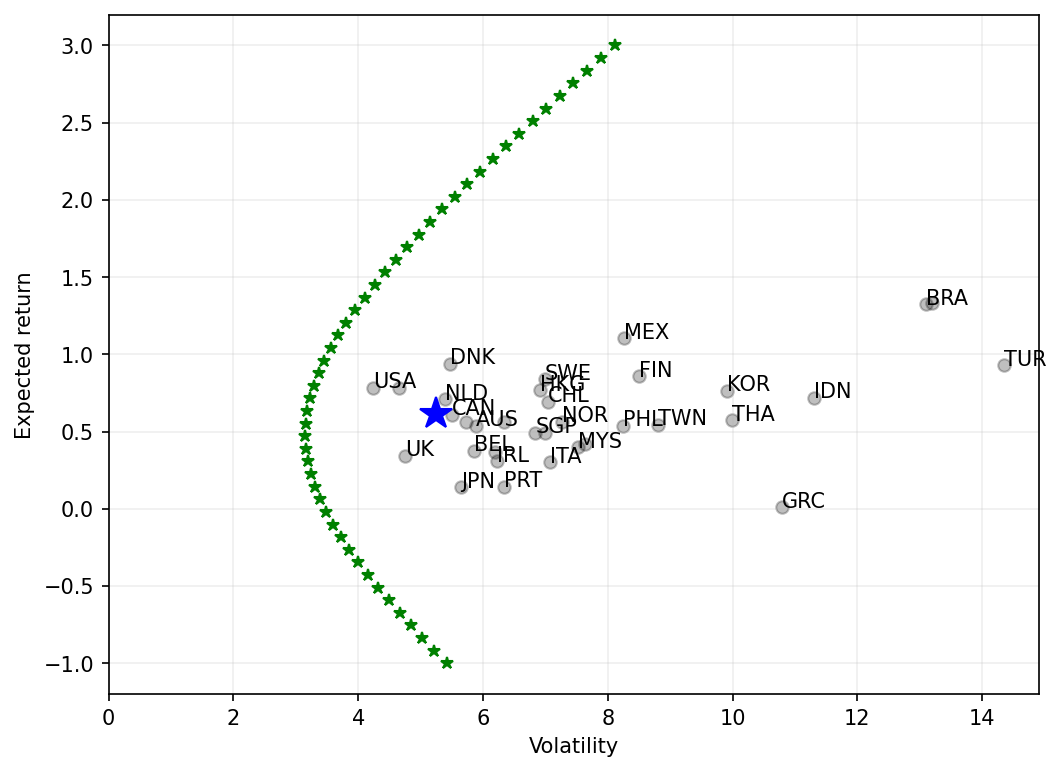

In [28]:
ccodes = {'Argentina': 'ARG', 'Australia': 'AUS', 'Austria': 'AUT', 'Belgium': 'BEL',
          'Brazil': 'BRA', 'Canada': 'CAN', 'Chile': 'CHL', 'Denmark': 'DNK',
          'Finland': 'FIN', 'France': 'FRA', 'Germany': 'DEU', 'Greece': 'GRC',
          'Hong Kong': 'HKG', 'Indonesia': 'IDN', 'Ireland': 'IRL', 'Italy': 'ITA',
          'Japan': 'JPN', 'Korea': 'KOR', 'Malaysia': 'MYS', 'Mexico': 'MEX',
          'Netherlands': 'NLD', 'New Zealand': 'NZL', 'Norway': 'NOR',
          'Philippines': 'PHL', 'Portugal': 'PRT', 'Singapore': 'SGP', 'Spain': 'ESP',
          'Sweden': 'SWE', 'Switzerland': 'CHE', 'Taiwan': 'TWN', 'Thailand': 'THA',
          'Turkey': 'TUR', 'UK': 'UK', 'USA': 'USA'}

fig, ax = plt.subplots(figsize=(8,6))
    
# Efficient frontier
ax.plot(tvols, trets, 'g*')

# Plot individual countries
vols = np.sqrt(np.diag(Σ))
ax.scatter(vols, μ, c='k', alpha=0.25)
for i,cntry in enumerate(rets.columns):
  if cntry not in ['Switzerland', 'France', 'Germany', 'New Zealand', 'Spain',
                   'Argentina', 'Austria']:
    ax.annotate(ccodes.get(cntry), (vols[i], μ[i]))

# EW portfolio
ewret = rets.mean(axis=1)
ax.plot(ewret.std(), ewret.mean(), 'b*', markersize=16)

# Style
ax.set_xlabel('Volatility')
ax.set_ylabel('Expected return')
ax.set_xlim(0, None)
ax.grid(alpha=0.2)
plt.show()

## The GMV portfolio

The *Global Minimum Variance* portfolio has the minimum possible variance of *any* portfolio, regardless of its expected return.

Therefore, the GMV is the portfolio that solves

\begin{equation*}
\begin{aligned}
\min_{\omega} \quad & \boldsymbol{\omega}'\boldsymbol{\Sigma}\boldsymbol{\omega} \\
\textrm{subject to} \quad & \boldsymbol{\omega}'\mathbf{1} = 1.
\end{aligned}
\end{equation*}

To implement this, all we have to do is redefine the constraint.

In [29]:
cons_gmv = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

gmv = sco.minimize(portvar, ewgts, constraints=cons_gmv, method='SLSQP')

gmv

     fun: 9.952993145085188
     jac: array([19.90605497, 19.90584886, 19.90542865, 19.90633798, 19.90595686,
       19.90492451, 19.90632367, 19.90502429, 19.90598559, 19.90626097,
       19.90607476, 19.90585196, 19.9056915 , 19.90563357, 19.90509951,
       19.90679097, 19.90609431, 19.90573311, 19.90591073, 19.90563965,
       19.90666974, 19.90623832, 19.90586305, 19.90584481, 19.90538704,
       19.90635622, 19.90580928, 19.90582561, 19.90633571, 19.90588653,
       19.90594053, 19.90605271, 19.90618753, 19.90577221])
 message: 'Optimization terminated successfully.'
    nfev: 1316
     nit: 35
    njev: 35
  status: 0
 success: True
       x: array([-0.01409767,  0.07838237, -0.0869706 ,  0.0097983 , -0.04945914,
       -0.03428684,  0.1318209 ,  0.16377405, -0.04548706, -0.0126508 ,
       -0.11924017, -0.01924829, -0.01260251, -0.02777548, -0.08397341,
        0.09241327,  0.18597079, -0.05696337,  0.12770124, -0.00443689,
       -0.12891991,  0.06914164, -0.09933991,  0.03218

In [30]:
mvs(gmv['x'])

(0.4828601367499688, 3.1548364688340325, 0.15305393528952857)

### The tangency portfolio

The portfolio with the maximum possible Sharpe ratio is called the *tangency portfolio*. To find it, we solve

\begin{equation*}
\begin{aligned}
\max_{\omega} \quad & \frac{\boldsymbol{\omega}'\boldsymbol{\mu}}{\sqrt{\boldsymbol{\omega}'\boldsymbol{\Sigma}\boldsymbol{\omega}}}\\
\textrm{subject to} \quad & \boldsymbol{\omega}'\mathbf{1} = 1.
\end{aligned}
\end{equation*}

The only complication is that `scipy` provides a method to minimize a function, but not maximize one. Not to worry: if we simply multiply our function by minus one and find the maximum, we will have found the minimum of the original function. (Maximizing $f(x) = -x^2$ is the same as minimizing $f(x) = x^2$. Either way the answer is $x=0$.)

In [31]:
def neg_sharpe(weights):
    return -mvs(weights)[2]

tng = sco.minimize(neg_sharpe, ewgts,
                   constraints=cons_gmv,  # note same constraints as GMV
                   method='SLSQP')

tng    

     fun: -0.3698955472551255
     jac: array([-2.50663608e-04, -2.26635486e-04, -3.37950885e-04, -2.08653510e-04,
       -8.44635069e-05, -2.31623650e-04, -2.81337649e-04, -8.93212855e-05,
       -3.15099955e-04, -3.58577818e-04, -2.13645399e-04, -2.23863870e-04,
       -7.23637640e-05, -3.23548913e-04,  2.95042992e-06, -2.05796212e-04,
       -2.46837735e-05, -4.00826335e-04,  6.32368028e-05, -1.05328858e-04,
       -4.64133918e-05, -8.78237188e-05, -2.57343054e-04, -1.11594796e-04,
       -4.43782657e-04, -2.89086252e-04, -1.82636082e-04, -2.13310122e-04,
       -2.84664333e-04, -7.04936683e-05, -3.26920301e-04, -1.23254955e-04,
       -2.18957663e-04, -1.36207789e-04])
 message: 'Optimization terminated successfully.'
    nfev: 1297
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([ 3.62232091e-02,  2.32556688e-01,  1.83680668e-01, -5.54333209e-01,
        6.71535661e-02, -3.51180313e-01,  7.43418971e-02,  1.13701513e+00,
        4.27211499e-02,  3.66182184e-01,

In [32]:
mvs(tng['x'])

(2.82437381871172, 7.635598318688827, 0.3698955472551255)

In [33]:
# Improvement in Sharpe ratio from GMV to tangency portfolio

mvs(tng['x'])[2] / mvs(gmv['x'])[2]

2.4167660018372135

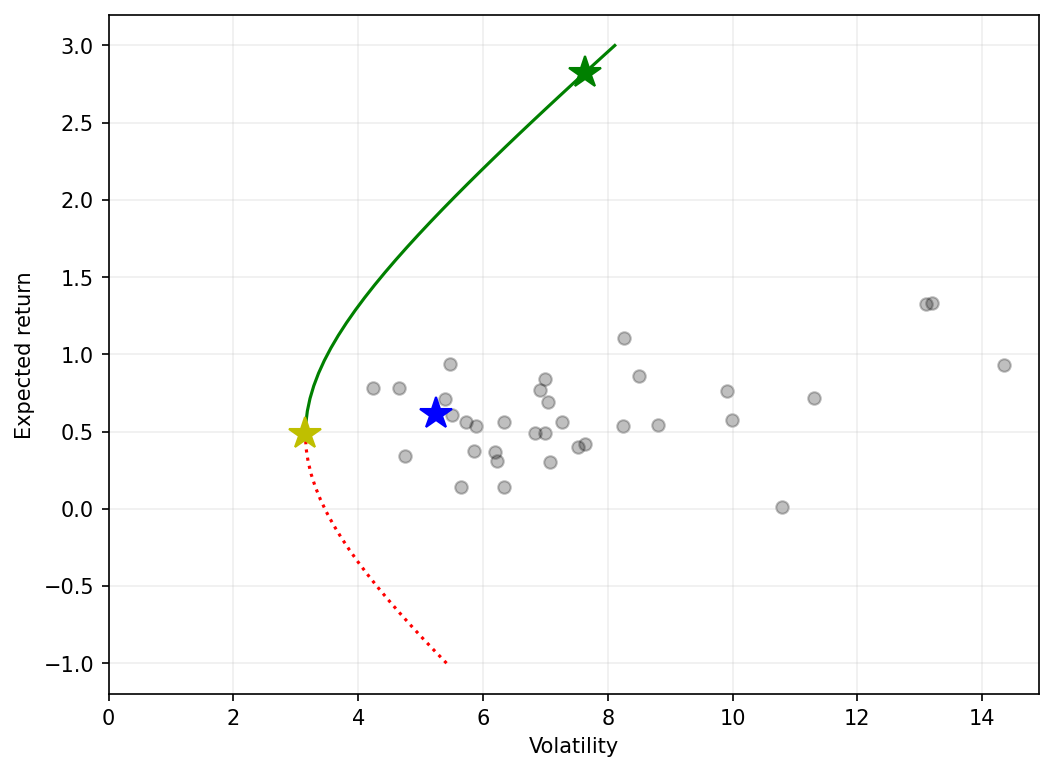

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
    
# Plot individual countries
vols = np.sqrt(np.diag(Σ))
ax.scatter(vols, μ, c='k', alpha=0.25)

# EW portfolio
ewret = rets.mean(axis=1)
ax.plot(ewret.std(), ewret.mean(), 'b*', markersize=16)

# Efficient frontier
gmv_μ, gmv_σ, _ = mvs(gmv['x'])
tng_μ, tng_σ, _ = mvs(tng['x'])
tvols = np.array(tvols)
ax.plot(tvols[trets>=gmv_μ], trets[trets>=gmv_μ], 'g')
ax.plot(tvols[trets<gmv_μ], trets[trets<gmv_μ], 'r:')

ax.plot(gmv_σ, gmv_μ, 'y*', markersize=16)
ax.plot(tng_σ, tng_μ, 'g*', markersize=16)

# Style
ax.set_xlabel('Volatility')
ax.set_ylabel('Expected return')
ax.set_xlim(0, None)
ax.grid(alpha=0.2)
plt.show()

### Weights in the optimized portfolios

In [36]:
pd.DataFrame({'tng': tng['x'],
              'gmv': gmv['x']},
             index=rets.columns).sort_values('tng', ascending=False)   

,tng,gmv
USA,1.437806,0.640859
Denmark,1.137015,0.163774
Switzerland,1.105515,0.226709
Netherlands,0.605585,-0.128920
France,0.366182,-0.012651
Australia,0.232557,0.078382
Hong Kong,0.202001,-0.012603
Austria,0.183681,-0.086971
Mexico,0.146195,-0.004437
Spain,0.144691,-0.111870


## Short-sale constraints

Many investors, including mutual funds, cannot engage in short selling. That is, they cannot hold a negative position in any asset.

We can represent their problem by adding one additional set of constraints to the problem that requires that all values of $\omega$ must be nonnegative.

\begin{equation*}
\begin{aligned}
\min_{\omega} \quad & \boldsymbol{\omega}'\boldsymbol{\Sigma}\boldsymbol{\omega} \\
\textrm{subjct to} \quad & \boldsymbol{\omega}'\boldsymbol{\mu} = \mu_p,\\
  &\boldsymbol{\omega}'\mathbf{1} = 1, \\
  &\omega_i\geq 0 \quad \forall i.
\end{aligned}
\end{equation*}

This problem is *much* harder to solve analytically, but trivial for the `scipy` algorithm. We simply add additional constraints to the problem.

The constraint that $\omega_i > 0$ is actually a special type of constraint called a *boundary*. These are easiest to implement by passing a list of upper- and lower-bounds to the algorithm.

In [37]:
bounds = [(0, 1) for w in range(N)]

In [38]:
bounds

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1)]

With a long-only portfolio there is no way to construct a portfolio with a return that is less than that of the lowest-return asset, or above that of the highest-return asset, so we have to choose a target return in that range.

In [39]:
tret = 1.2

In [42]:
# make sure the target return is feasible
# "assert" raises an exception if the condition is false

assert tret<max(μ), 'Target return is infeasible'

In [43]:
cons = [
    # expected return equals target return
    {'type': 'eq', 'fun': lambda w:  mvs(w)[0] - tret},  
    
    # weights sum to one
    {'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}
]

In [44]:
p2 = sco.minimize(portvar, ewgts, constraints=cons, bounds=bounds, method='SLSQP')

In [45]:
p2['message']

'Optimization terminated successfully.'

In [46]:
p2['x']

array([2.90163157e-01, 3.10598368e-12, 0.00000000e+00, 3.89299713e-12,
       2.74925908e-01, 7.39815908e-12, 7.92833758e-12, 1.88805659e-01,
       0.00000000e+00, 1.13865807e-12, 0.00000000e+00, 0.00000000e+00,
       2.04397031e-12, 0.00000000e+00, 5.58385989e-12, 0.00000000e+00,
       1.67746848e-11, 0.00000000e+00, 6.53679300e-12, 2.46105277e-01,
       4.54589676e-12, 6.25698166e-12, 0.00000000e+00, 2.02278636e-12,
       1.64455693e-12, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.64039658e-11, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.03061134e-11, 1.88368257e-11])

In [47]:
mvs(p2['x'])

(1.2000000000769495, 8.043573775668056, 0.14918741762610163)

In [ ]:
w = pd.Series(p2['x'], index=rets.columns)

w[w>0.0001].sort_values(ascending=False)

In [48]:
p2['x'].sum()

1.0000000001356513

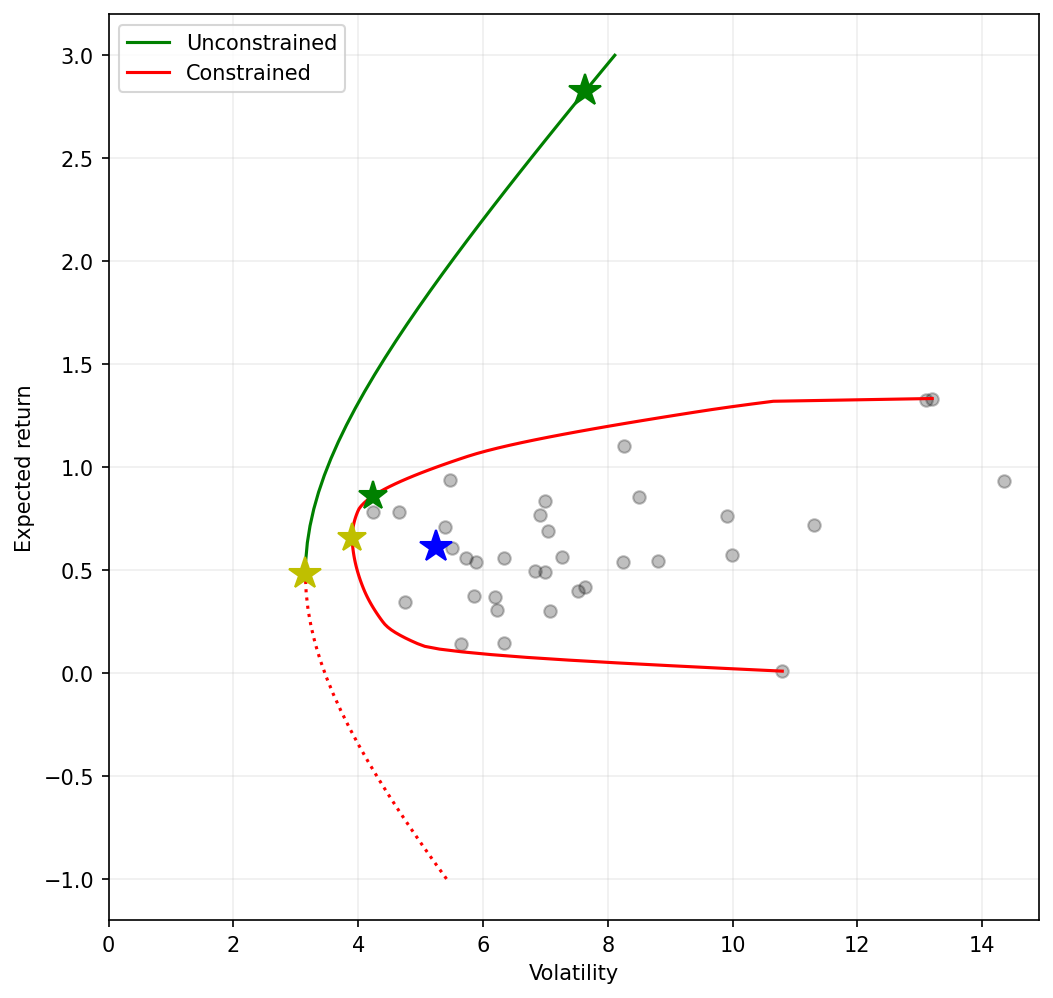

In [49]:
fig, ax = plt.subplots()

# Plot individual countries
vols = np.sqrt(np.diag(Σ))
ax.scatter(vols, μ, c='k', alpha=0.25)

# EW portfolio
ewret = rets.mean(axis=1)
ax.plot(ewret.std(), ewret.mean(), 'b*', markersize=16)

# Efficient frontier
gmv_μ, gmv_σ, _ = mvs(gmv['x'])
tng_μ, tng_σ, _ = mvs(tng['x'])
tvols = np.array(tvols)
ax.plot(tvols[trets>=gmv_μ], trets[trets>=gmv_μ], 'g', label='Unconstrained')
ax.plot(tvols[trets<gmv_μ], trets[trets<gmv_μ], 'r:')

ax.plot(gmv_σ, gmv_μ, 'y*', markersize=16)
ax.plot(tng_σ, tng_μ, 'g*', markersize=16)

################################################################
# Long-only portfolios
################################################################

# Efficient frontier
tvols_c = []
trets_c = np.linspace(μ.min(), μ.max(), 100)
for tret in trets_c:
    cons = ({'type': 'eq', 'fun': lambda w:  mvs(w)[0] - tret},
            {'type': 'eq', 'fun': lambda w:  np.sum(w) - 1})
    res = sco.minimize(portvar, ewgts, constraints=cons, bounds=bounds, method='SLSQP')
    tvol = np.sqrt(res['fun'])
    tvols_c.append(tvol)
ax.plot(tvols_c, trets_c, 'r', label='Constrained')

# GMV
gmv_c = sco.minimize(portvar, ewgts, constraints=cons_gmv, bounds=bounds, method='SLSQP')
m,v,_ = mvs(gmv_c['x'])
ax.plot(v, m, 'y*', markersize=14)

# Tangency
tng_c = sco.minimize(neg_sharpe, ewgts, constraints=cons_gmv, bounds=bounds, method='SLSQP')
m,v,_ = mvs(tng_c['x'])
ax.plot(v, m, 'g*', markersize=14)

ax.set_xlabel('Volatility')
ax.set_ylabel('Expected return')

ax.set_xlim(0, None)
ax.legend(loc='upper left')
ax.grid(alpha=0.2)
plt.show()